In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set initial seed for random sampling
rng = np.random.default_rng(5731)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load in dataset and set up new columns
data = pd.read_csv('zaw_table_4.csv')
data['Intercept'] = np.ones(data['Name'].count())
data['log_sigma'] = np.log10(data['sigma'])
data['log_sigma_2'] = np.log10(data['sigma'])**2
# Update black hole information to include offset
data['log_MassBH'] = np.log10(data['MassBH'])
data['log_E_sigma'] = np.log10(1 + data['e_sigma']/data['sigma'])
data['log_e_sigma'] = -np.log10(1 - data['e_sigma']/data['sigma'])
data['log_E_MassBH'] = np.log10(1 + data['E_MassBH']/data['MassBH'])
data['log_e_MassBH'] = -np.log10(1 - data['e_MassBH']/data['MassBH'])

# Set up dataset
X = np.array(data[['Intercept', 'log_sigma']])
X_quad = np.array(data[['Intercept', 'log_sigma', 'log_sigma_2']])
Y = np.array(data['log_MassBH'])

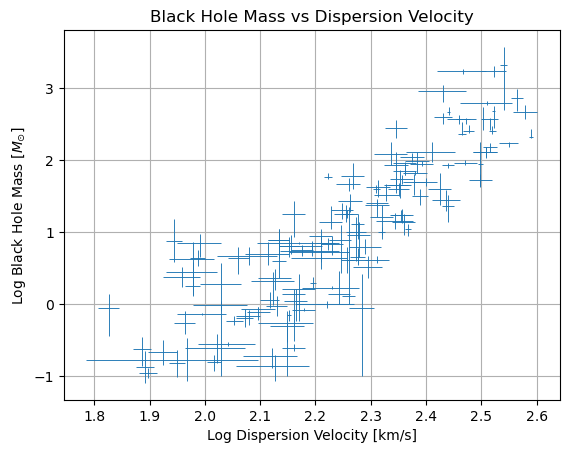

In [3]:
xerr = np.vstack([data['log_e_sigma'], data['log_E_sigma']])
yerr = np.vstack([data['log_e_MassBH'], data['log_E_MassBH']])

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], yerr, xerr, fmt='none', elinewidth=0.66)
plt.grid()
plt.title('Black Hole Mass vs Dispersion Velocity')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.show()

# Linear Model

In [4]:
def linear_regression(X, Y, m=0, c=1e2, samples=1000):
    coords = {
        'galaxy': range(X.shape[0]),
        'parameters': ['Intercept', 'Sigma'],
    }
    
    with pm.Model(coords=coords):
        x = pm.Data('x', X, dims=['galaxy', 'parameters'])

        # Model parameters
        betas = pm.Normal('beta', mu=m, sigma=c, dims='parameters')
        epsilon = pm.HalfNormal('epsilon', sigma=c)

        # Model
        mu = x @ betas

        # Likelihood
        y = pm.Normal('MassBH', mu=mu, sigma=epsilon, observed=Y)

        # Sample posterior
        trace = pm.sample(samples)
        return trace

In [5]:
# mle_beta = np.linalg.inv(X.T @ X) @ X.T @ Y
# mle_lam = Y.shape[0] / ((Y - X @ mle_beta).T @ (Y - X @ mle_beta)).item()
trace = linear_regression(X, Y) #, mle_beta.T[0], 1/np.sqrt(mle_lam))
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Intercept],-10.243,0.579,-11.332,-9.178,0.017,0.012,1182.0,1328.0,1.0
beta[Sigma],5.008,0.256,4.546,5.502,0.007,0.005,1184.0,1329.0,1.0
epsilon,0.532,0.032,0.472,0.590,0.001,0.001,1913.0,1721.0,1.0


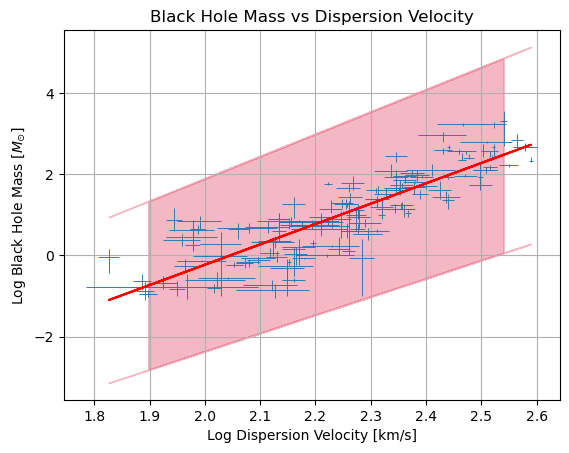

In [6]:
# Bad method of plotting (Update this method)
Y_mean = X @ np.quantile(np.array(trace.posterior.beta), 0.50, axis=(0, 1))
Y_lower = X @ np.quantile(np.array(trace.posterior.beta), 0.025, axis=(0, 1))
Y_upper = X @ np.quantile(np.array(trace.posterior.beta), 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], yerr, xerr, fmt='none', elinewidth=0.66)
plt.plot(data['log_sigma'], Y_mean, color='red', label='Normal Best-fit Line')
plt.fill_between(data['log_sigma'], Y_lower, Y_upper, color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Black Hole Mass vs Dispersion Velocity')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()

# Quadratic Model

In [7]:
def quadratic_regression(X, Y, m=0, c=1e2, samples=1000):
    coords = {
        'galaxy': range(X.shape[0]),
        'parameters': ['Intercept', 'Sigma', 'Sigma^2'],
    }
    
    with pm.Model(coords=coords):
        x = pm.Data('x', X, dims=['galaxy', 'parameters'])

        # Model parameters
        betas = pm.Normal('beta', mu=m, sigma=c, dims='parameters')
        epsilon = pm.HalfNormal('epsilon', sigma=c)

        # Model
        mu = x @ betas

        # Likelihood
        y = pm.Normal('MassBH', mu=mu, sigma=epsilon, observed=Y)

        # Sample posterior
        trace = pm.sample(samples)
        return trace

In [8]:
trace_quad = quadratic_regression(X_quad, Y)
pm.summary(trace_quad)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 609 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Intercept],10.917,6.170,-0.605,22.081,0.218,0.159,807.0,812.0,1.01
beta[Sigma],-14.036,5.536,-24.056,-3.639,0.196,0.142,805.0,818.0,1.01
beta[Sigma^2],4.258,1.236,1.888,6.450,0.044,0.032,805.0,823.0,1.00
epsilon,0.510,0.031,0.454,0.570,0.001,0.001,1191.0,1163.0,1.00


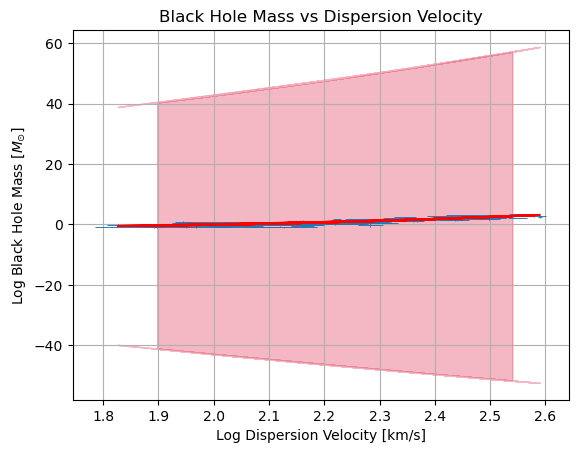

In [9]:
# Bad method of plotting (Update this method)
Y_mean_quad = X_quad @ np.quantile(np.array(trace_quad.posterior.beta), 0.50, axis=(0, 1))
Y_lower_quad = X_quad @ np.quantile(np.array(trace_quad.posterior.beta), 0.025, axis=(0, 1))
Y_upper_quad = X_quad @ np.quantile(np.array(trace_quad.posterior.beta), 0.975, axis=(0, 1))

plt.figure()
plt.errorbar(data['log_sigma'], data['log_MassBH'], yerr, xerr, fmt='none', elinewidth=0.66)
plt.plot(data['log_sigma'], Y_mean_quad, color='red', label='Normal Best-fit Line')
plt.fill_between(data['log_sigma'], Y_lower_quad, Y_upper_quad, color='crimson', alpha=0.3, label="95% Credible Region")
plt.title('Black Hole Mass vs Dispersion Velocity')
plt.xlabel(r'Log Dispersion Velocity [km/s]')
plt.ylabel(r'Log Black Hole Mass [$M_{\odot}$]')
plt.grid()
plt.show()